# Import libs

In [9]:
from seirpinn.pinn import SeirPINN
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.optim as optim
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Preprocess data

In [10]:
raw_data = pd.read_csv("covid_data.csv")

In [11]:
raw_data.head()

,TIME,E,I,R,S,t
0,2020-03-04,1,1,0,4999998.0,0.0
1,2020-03-05,0,1,0,4999999.0,1.0
2,2020-03-06,1,2,0,4999997.0,2.0
3,2020-03-07,0,2,0,4999998.0,3.0
4,2020-03-08,0,2,0,4999998.0,4.0


In [12]:
source_data = raw_data[23:]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(source_data[["S", "E", "I", "R"]])


# Train network

## Setup options

In [27]:
options = {
    "N": 5e6,
    "NUM_EPOCHS": 100000,
    "LEARNING_RATE": 5e-4,
    "PARAMETERS_RANGE": {
        "contact_rate" : {
            "center": 10,
            "radius": 10
        },
        "incubation_rate" : {
            "center": 10,
            "radius": 10
        },
        "infective_rate" : {
            "center": 10,
            "radius": 10
        }
        
    },
    "NETWORK": {
        "nodes": 60,
        "hidden_layers_amount": 2,
        "activation_function": torch.tanh
    },
    "LOSS": {
        "THRESHOLD": 1e-6,
        "BALANCE_DELTA_U": 1,
        "BALANCE_DELTA_F": 1
    }
}

## Execute training

In [23]:
pinn = SeirPINN(source_data["t"].to_numpy(), data_scaled[:, 2], options)

optimizer = optim.Adam(pinn.params, lr=options["LEARNING_RATE"])
pinn.optimizer = optimizer

predicted_data = pinn.train(options["NUM_EPOCHS"])

100%|██████████| 100000/100000 [12:32<00:00, 132.92it/s, loss=0.000247, lossU=0.000226, lossF=2.14e-5, Contact_rate=0.279, Incubation_rate=0.468, Infective_rate=11.1, LR=0.001]


# Check calibration

In [24]:
def ode(y, t, contact_rate, infective, incubation):
    S, E, I, R = y
    alpha = 1 / incubation
    gamma = 1 / infective
    beta = contact_rate / infective

    dSdt = - beta * S * I
    dEdt = beta * S * I - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I

    return dSdt, dEdt, dIdt, dRdt

In [25]:
y0 = data_scaled[0, 0], data_scaled[0, 1], data_scaled[0, 2], data_scaled[0, 3]
t = np.linspace(0, len(data_scaled), len(data_scaled))

res = odeint(ode, y0, t, args=(pinn.contact_rate.item(), 
                               pinn.infective_rate.item(), 
                               pinn.incubation_rate.item()))

simulated_i = np.array([item[2] for item in res])

/var/folders/y1/0xfcbwy53bsd0708_4_bv7nw0000gn/T/ipykernel_51502/4128318735.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')


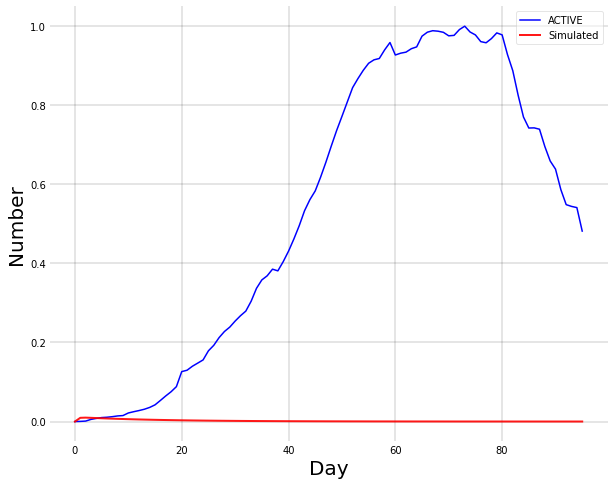

In [26]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

x = range(0, len(data_scaled))

ax.plot(x, data_scaled[:, 2], c='blue', label='ACTIVE')
ax.plot(x, simulated_i, c="red",alpha=0.9, lw=2, label='Simulated')

ax.set_xlabel('Day', fontsize=20)
ax.set_ylabel('Number', fontsize=20)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.show()
